In [49]:
import os

import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

import warnings
warnings.filterwarnings('ignore')

# ------- GLOBAL VARIABLES -------
# MNIST dataset
MNIST_TRAINING_IMAGES_PATH = "dataset/train-images.idx3-ubyte"
MNIST_TRAINING_LABELS_PATH = "dataset/train-labels.idx1-ubyte"
MNIST_TEST_IMAGES_PATH = "dataset/t10k-images.idx3-ubyte"
MNIST_TEST_LABELS_PATH = "dataset/t10k-labels.idx1-ubyte"


#### Some utility functions

In [50]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mnist(_set='training'):
    
    if _set == 'training':
        images = MNIST_TRAINING_IMAGES_PATH
        labels = MNIST_TRAINING_LABELS_PATH
    elif _set == 'test':
        images = MNIST_TEST_IMAGES_PATH
        labels = MNIST_TEST_LABELS_PATH
    else:
        raise ValueError('Invalid set: provide either "training" or "test"')
    
    with open(images, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        num_images = int.from_bytes(f.read(4), 'big')
        num_rows = int.from_bytes(f.read(4), 'big')
        num_cols = int.from_bytes(f.read(4), 'big')
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, num_rows * num_cols)
    
    with open(labels, 'rb') as f:
        _ = int.from_bytes(f.read(4), 'big')
        labels = np.frombuffer(f.read(), dtype=np.uint8)
        
    return data, labels
        
def plot_components(restricted_boltzmann_machine):
    plt.figure(figsize=(20, 20))
    for i in range(restricted_boltzmann_machine.num_hidden):
        plt.subplot(10, 10, i + 1)
        plt.imshow(restricted_boltzmann_machine.weights[i].reshape((28, 28)), cmap=plt.cm.RdBu,
                   interpolation='nearest', vmin=-2.5, vmax=2.5)
        plt.axis('off')
    plt.suptitle(f'{restricted_boltzmann_machine.num_hidden} components extracted by RBM', fontsize=16)


In [51]:
class RestrictedBoltzmannMachine:
    
    def __init__(self, num_visible, num_hidden):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.weights = np.random.randn(num_hidden, num_visible) * np.sqrt(6 / (num_hidden + num_visible))
        self.hidden_bias = np.zeros((num_hidden, 1))
        self.visible_bias = np.zeros((num_visible, 1))
        
        
    def fit(self, data, epochs, epsilon, learning_rate=0.1, batch_size=100, verbose=False):
        tot_epoch = epochs
        error = epsilon
        while epochs > 0 and error >= epsilon:
            
            for batch in range(len(data) // batch_size):
                batch = data[batch * batch_size: (batch + 1) * batch_size]
                error = self.train_one_step(batch, learning_rate)
                
            if verbose:
                print(f'Epoch: {tot_epoch - epochs}, Error: {error}')
            epochs -= 1
                
    def train_one_step(self, batch, learning_rate):
        
            v0 = (batch > np.random.rand(*batch.shape)).astype(int)
            h0_activation = sigmoid(np.add(np.dot(self.weights, v0.T), self.hidden_bias))
            h0 = (h0_activation > np.random.rand(*h0_activation.shape)).astype(int)
            
            v1_activation = sigmoid(np.add(np.dot(h0.T, self.weights), self.visible_bias.T))
            v1 = (v1_activation > np.random.rand(*v1_activation.shape)).astype(int)
            h1_activation = sigmoid(np.add(np.dot(self.weights, v1.T), self.hidden_bias))
            
            wake = np.dot(h0_activation, v0)
            dream = np.dot(h1_activation, v1)
            
            error = np.mean(np.square(v0 - v1))
            
            dM = np.subtract(wake, dream)
            dhb = np.subtract(h0_activation, h1_activation).sum(axis=1).reshape(-1, 1)
            dvb = np.subtract(v0, v1).sum(axis=0).reshape(-1, 1)
        
            self.weights = self.weights + learning_rate * dM
            self.hidden_bias = self.hidden_bias + learning_rate * dhb
            self.visible_bias = self.visible_bias + learning_rate * dvb
        
            return error
    
    def save(self, path='model/rbm.npz'):
        if not os.path.exists('model'):
            os.makedirs('model')
        np.savez(path, weights=self.weights, hidden_bias=self.hidden_bias, visible_bias=self.visible_bias)
            

Epoch: 0, Error: 0.11136479591836734
Epoch: 1, Error: 0.09789540816326531
Epoch: 2, Error: 0.09278061224489796
Epoch: 3, Error: 0.09065051020408163
Epoch: 4, Error: 0.089375
Epoch: 5, Error: 0.08516581632653061
Epoch: 6, Error: 0.08466836734693878
Epoch: 7, Error: 0.08452806122448979
Epoch: 8, Error: 0.08358418367346938
Epoch: 9, Error: 0.08256377551020408
Epoch: 10, Error: 0.08127551020408164
Epoch: 11, Error: 0.08068877551020408
Epoch: 12, Error: 0.08114795918367347
Epoch: 13, Error: 0.07910714285714286
Epoch: 14, Error: 0.08024234693877551
Epoch: 15, Error: 0.07966836734693877
Epoch: 16, Error: 0.08182397959183674
Epoch: 17, Error: 0.07895408163265306
Epoch: 18, Error: 0.07994897959183674
Epoch: 19, Error: 0.07934948979591837
Epoch: 20, Error: 0.07936224489795918
Epoch: 21, Error: 0.07885204081632653
Epoch: 22, Error: 0.07838010204081633
Epoch: 23, Error: 0.07926020408163266
Epoch: 24, Error: 0.07875
Epoch: 25, Error: 0.0796045918367347
Epoch: 26, Error: 0.079375
Epoch: 27, Error: 0

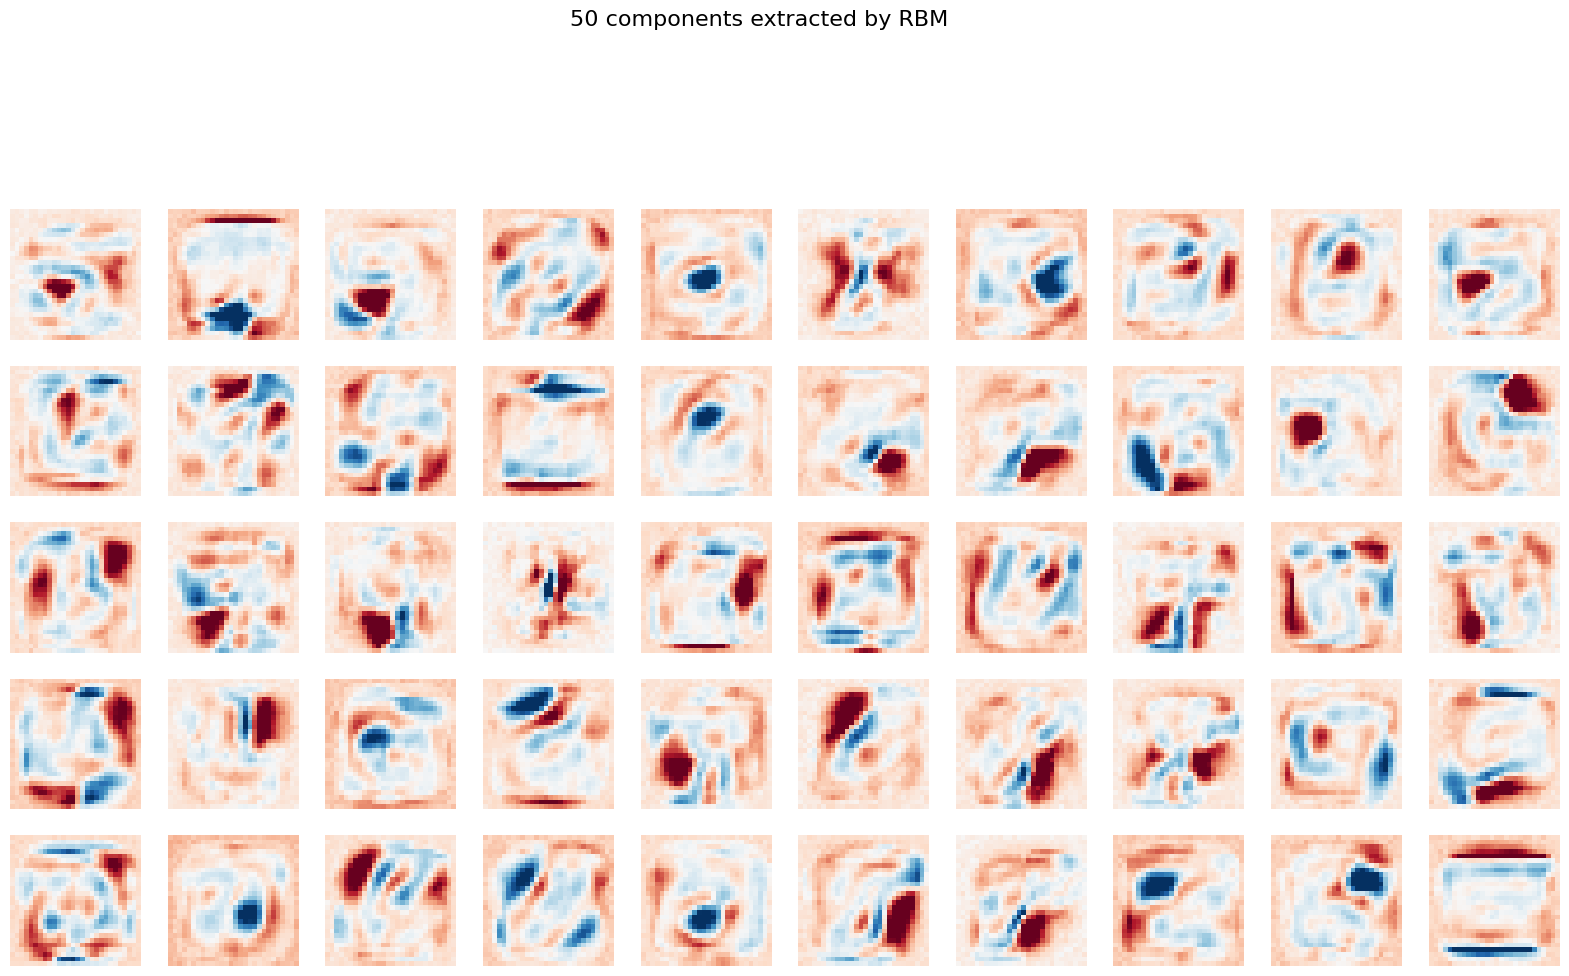

In [52]:
x_train, y_train = mnist('training')
rbm = RestrictedBoltzmannMachine(x_train.shape[1], 50)
rbm.fit(x_train, epochs=50, learning_rate=0.001, epsilon=0.05, verbose=True)
plot_components(rbm)
rbm.save()